In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
PATH = 'drive/My Drive/000 STUDIA/MASTER/'
FILENAME = "datasets.zip"
os.listdir(PATH)

['datasets.zip',
 'read_errors.json',
 'not_enough_parts.json',
 'some_parse_failures.json',
 'parse.json',
 '.ipynb_checkpoints',
 'model_notes-n-chords_dummy',
 'test_idx.json',
 'model_dummy_N+CH_128',
 'model_dummy_N+CH_64',
 'embeddings',
 'model_dummy_N+CH_256',
 'parse_2.json',
 'model_dummy_N+CH_256_stateful',
 'model_dummy_N+CH_512',
 'model_dummy_N+CH_128_stateful',
 'model_dummy_N+CH_64_stateful']

In [ ]:
import json

with open(os.path.join(PATH, "read_errors.json"), "r") as handle:
  read_errors = set(json.load(handle))

with open(os.path.join(PATH, "not_enough_parts.json"), "r") as handle:
  incomplete_songs = set(json.load(handle))

skip = read_errors | incomplete_songs

len(read_errors), len(incomplete_songs), len(skip)

(69, 1853, 1922)

In [ ]:
from zipfile import ZipFile

archive = ZipFile(os.path.join(PATH, FILENAME))

midi_paths = []
for path in archive.namelist():
  if path not in skip and path.endswith('.mid') and 'nokey' in path:
    midi_paths.append(path)

len(midi_paths)

17954

In [ ]:
import pandas as pd

catalog_df = pd.DataFrame.from_records(map(lambda x : x.split("/")[3:], midi_paths), columns=["artist", "songname", "songpart"])
catalog_df["songpart"] = catalog_df["songpart"].apply(lambda x : x.split('.')[0].split('_')[0])
catalog_df

,artist,songname,songpart
0,a-day-to-remember,downfall-of-us-all,intro-and-verse
1,a-day-to-remember,downfall-of-us-all,pre-chorus-and-chorus
2,a-g-cook,superstar,chorus
3,a-g-cook,superstar,pre-chorus-and-chorus
4,a-great-big-world,say-something,chorus
...,...,...,...
17949,zun,wind-circulation---wind-tour,verse
17950,zun,winds-of-time,chorus
17951,zun,witching-dream,chorus
17952,zun,youkai-space-travel,intro


In [ ]:
# import matplotlib.font_manager
# [f.name for f in matplotlib.font_manager.fontManager.ttflist]

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Serif'

Text(0.5, 1.0, 'Top 30 artists')

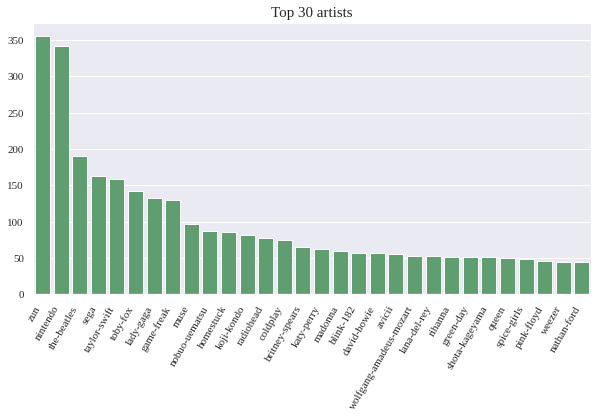

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font="Liberation Serif")

plt.figure(figsize=(10, 5))

top_artists = catalog_df.artist.value_counts()[:30]
ax = sns.barplot(x=top_artists.index, y=top_artists.values, color="g")

_ = plt.xticks(
    rotation=60, 
    horizontalalignment='right',
    fontweight='light',
)

plt.title("Top 30 artists", size=15)

Text(0.5, 1.0, 'Song parts')

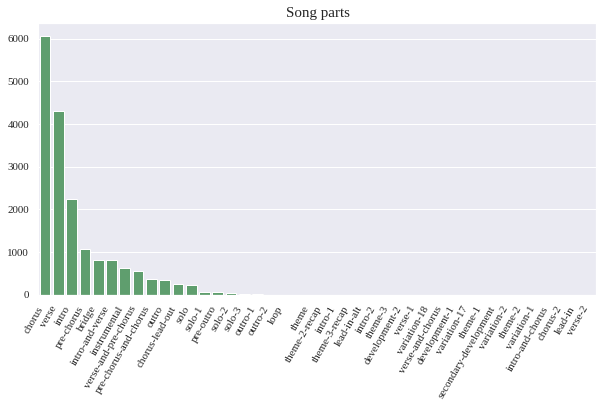

In [ ]:
plt.figure(figsize=(10, 5))

top_songparts = catalog_df.songpart.value_counts()
ax = sns.barplot(x=top_songparts.index, y=top_songparts.values, color="g")

_ = plt.xticks(
    rotation=60, 
    horizontalalignment='right',
    fontweight='light',
)
plt.title("Song parts", size=15)

Text(0.5, 1.0, 'Distribution of song modes')

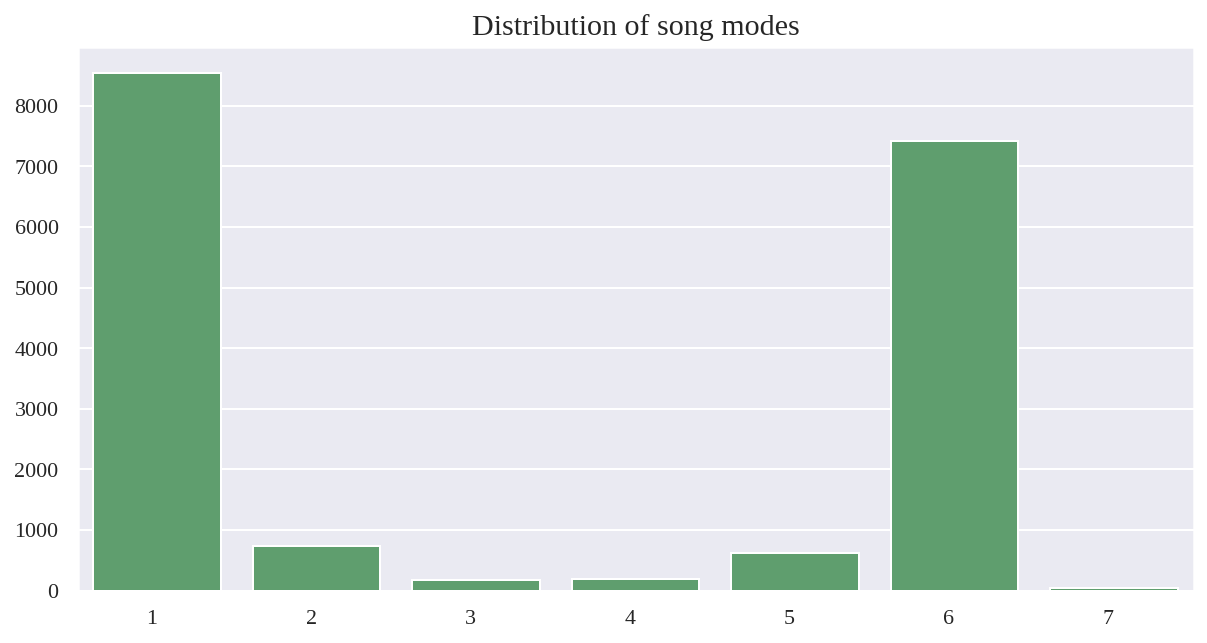

In [ ]:
plt.figure(figsize=(10, 5))

modes_df = pd.DataFrame({"song_mode": modes})
top_modes = modes_df.song_mode.value_counts()
ax = sns.barplot(x=top_modes.index, y=top_modes.values, color="g")

_ = plt.xticks(
    rotation=0, 
    horizontalalignment='right',
    fontweight='light',
)
plt.title("Distribution of song modes", size=15)

In [ ]:
import music21 as mc
import json

def read_midi_from_archive(archive, path):
  mf = mc.midi.MidiFile()
  mf.readstr(archive.read(path))
  return mc.midi.translate.midiFileToStream(mf)

MODE_TO_OFFSET = {
    "1": 0,
    "2": 2, 
    "3": 4,
    "4": 5,
    "5": 7,
    "6": 9,
    "7": 11
}
def read_mode(archive, midi_path):
  symbol_nokey_path = midi_path.replace('/pianoroll/', '/event/').replace('nokey.mid', 'symbol_nokey.json')
  read_data = archive.read(symbol_nokey_path)
  json_data = json.loads(read_data)
  return json_data.get("metadata", {}).get("mode", "?") 

def translate_to_c(sample, mode, debug=False):
  offset = MODE_TO_OFFSET.get(mode, -1)
  if offset > 0:
    if debug:
      print("Mode: ", mode)
    for part in sample.parts:
      part.transpose(offset, inPlace=True)
  return sample


In [ ]:
from collections import Counter

def estimate_part_type(part):
  types = [type(elem) for elem in part.notesAndRests]
  if mc.note.Note not in types:
    return "chords"
  else:
    counts = Counter(types)
    return "notes" if counts.get(mc.note.Note, 0) > counts.get(mc.chord.Chord, 0) else "chords"

def _estimate_single_part_type(part):
  if part.voices:
    return "voices"
  counts = Counter([type(elem) for elem in part.notes])
  if counts.get(mc.note.Note, 0) > counts.get(mc.chord.Chord, 0):
    return "notes"
  elif counts.get(mc.note.Note, 0) < counts.get(mc.chord.Chord, 0):
    return "chords"
  return "?"
      
def estimate_parts_types(part1, part2):
  """
  LOGIC:
  1. For each part separately, if it has more notes than chords, then it's notes. If it has more chords than notes, then it's chords.
    If the number of notes and chords is equal, keep it as undefined.
  2. Check for duplicate part types, 2x. notes or 2x. chords.
    Raise exception if both were undefined (same count of notes and chords in both parts)
    Otherwise, compare counts of chords between parts. Assign 'chords' type to the one which has more chords and 'notes' to the other one.
    If counts of chords were equal, then compare lengths of parts. The shorter one will be assigned to 'chords' and longer one to 'notes'. 
    If there was no match - lenghts are also equal, then raise exception. (? will this line of code execute ?)
  3. If there were no duplicate part types, and there is 'undefined' mark left, then fill it with the remaining type.
  4. At the end, two types should be different and defined. (assert)
  """
  t1, t2 = "?", "?"
  
  t1 = _estimate_single_part_type(part1)
  t2 = _estimate_single_part_type(part2)

  if t1 == t2:    
    counts1 = Counter([type(elem) for elem in part1.notes])
    counts2 = Counter([type(elem) for elem in part2.notes])
    if t1 == "?":
      raise Exception("Counts of Notes and Chords are equal in both parts!")
    else:
      if counts1.get(mc.chord.Chord, 0) > counts2.get(mc.chord.Chord, 0):
        t1, t2 = "chords", "notes"
      elif counts1.get(mc.chord.Chord, 0) < counts2.get(mc.chord.Chord, 0):
        t1, t2 = "notes", "chords"
      else:
        if len(part1.notes) < len(part2.notes):
          t1, t2 = "chords", "notes"
        elif len(part1.notes) < len(part2.notes):
          t1, t2 = "notes", "chords"
        else:
          raise Exception("NO WAY I CAN'T IDENTIFY THOSE PARTS")
  else:
    if t1 == "?":
      t1 = "notes" if t2 == "chords" else "chords"
    elif t2 == "?":
      t2 = "notes" if t1 == "chords" else "chords"
  
  assert t1 != "?"
  assert t2 != "?"
  assert t1 != t2
  return t1, t2

def extract_as_notes(part):
  pitches, names, durations = [], [], []
  for nt in part.notesAndRests:
    if isinstance(nt, mc.note.Note):
      pitches.append(max(0.0, nt.pitch.ps))
      names.append(nt.pitch.nameWithOctave)
    elif isinstance(nt, mc.note.Rest):
      pitches.append(-1.0)
      names.append("REST")
    elif isinstance(nt, mc.chord.Chord):
      # !!! TAKE ONLY FIRST NOTE
      first = nt.pitches[0]
      pitches.append(max(0.0, first.ps))
      names.append(first.nameWithOctave)
    else:
      raise Exception(f"Unknown note type: {type(nt)} ???")
    durations.append(nt.quarterLength)
  return pitches, names, durations

def extract_as_chords(part, octave_invariant=False):
  pitches, names, durations = [], [], []
  for nt in part.notesAndRests:
    if isinstance(nt, mc.note.Note):
      pitches.append([max(0.0, nt.pitch.ps)])
      if octave_invariant:
        names.append([nt.pitch.name])
      else:
        names.append([nt.pitch.nameWithOctave])
    elif isinstance(nt, mc.note.Rest):
      pitches.append([-1.0])
      names.append(["REST"])
    elif isinstance(nt, mc.chord.Chord):
      pitches.append([max(0.0, pitch.ps) for pitch in nt.pitches])
      if octave_invariant:
        names.append([pitch.name for pitch in nt.pitches])
      else:
        names.append([pitch.nameWithOctave for pitch in nt.pitches])
    else:
      raise Exception(f"Unknown note type: {type(nt)} ???")
    durations.append(nt.quarterLength)
  return pitches, names, durations

def _get_most_common(part):
  if len(part.notesAndRests) == 0:
    return None
  else:
    types = list(map(type, part.notesAndRests))
    return Counter(types).most_common()

def extract_music(midi_sample, chords_octave_invariant=False):
  result = {}
  if len(midi_sample.parts) != 2:
    raise Exception("Midi sample given does not have exactly TWO parts")

  part_types = estimate_parts_types(midi_sample.parts[0], midi_sample.parts[1])

  for part_type, part in zip(part_types, midi_sample.parts):
    pitches, names, durations = None, None, None

    if part_type in result:
      raise Exception(f"Part of type {part_type} have already been parsed!")

    if part_type == "notes" and part.notes:
      pitches, names, durations = extract_as_notes(part)
    elif part_type == "chords" and part.notes:
      pitches, names, durations = extract_as_chords(part, octave_invariant=chords_octave_invariant)
    elif part_type == "voices":
      longest_voice = -1
      for xx, voicepart in enumerate(part.voices):
        most_common = _get_most_common(voicepart)
        types = list(map(lambda x : x[0], most_common))
        # if mc.chord.Chord not in map(lambda x : x[0], most_common):
        if types and types[0] == mc.note.Note:
          tmp_pitches, tmp_names, tmp_durations = extract_as_notes(voicepart)
          if len(tmp_pitches) > longest_voice:
            pitches, names, durations = tmp_pitches, tmp_names, tmp_durations
            longest_voice = len(pitches)
            part_type = "notes"
    else:
      if part.notes:
        raise Exception(f"Part type '{part_type}' was not recognized.")
    
    if pitches and names and durations:
      result[part_type] = {
          "pitches": pitches,
          "names": names,
          "durations": durations
      }

  return result

Some songs don't have the melody! We can keep them as test set. :)

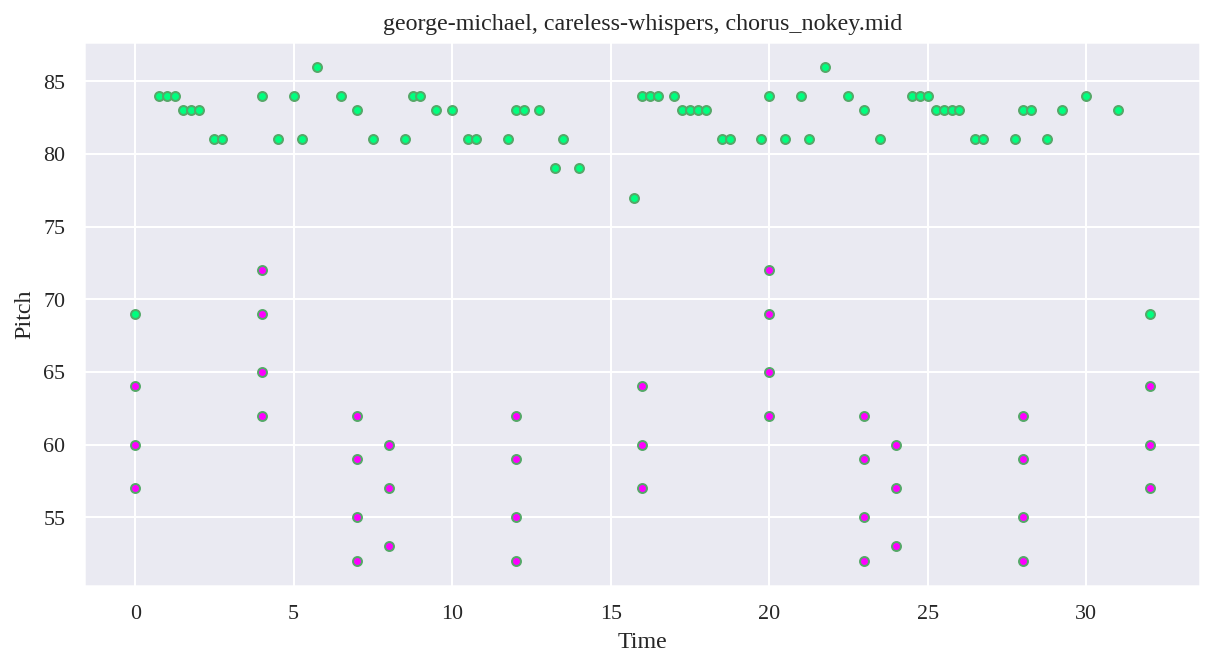

In [ ]:
import matplotlib.lines as mlines

def show_song(sample, title=None):
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 1, 1)
  
  for part in sample.parts:
    x = []
    y = []
    if isinstance(part.notes[0], mc.chord.Chord):
      c = "magenta"
      for ch in part.notes:
        for pitch in ch.pitches:
          x.append(ch.offset)
          y.append(pitch.ps)
    elif isinstance(part.notes[0], mc.note.Note):
      c = "springgreen"
      for nt in part.notes:
          x.append(nt.offset)
          y.append(nt.pitch.ps)

    ax.scatter(x, y, alpha=1.0, s=20, color=c, edgecolor='g')

  if title:
    plt.title(title)

  plt.xlabel("Time")
  plt.ylabel("Pitch")
  plt.show()

for idx in [5238]:
  path = midi_paths[idx]
  sample = read_midi_from_archive(archive, path)
  sample = translate_to_c(sample, read_mode(archive, path))
  show_song(sample, title=", ".join(path.split('/')[3:]))

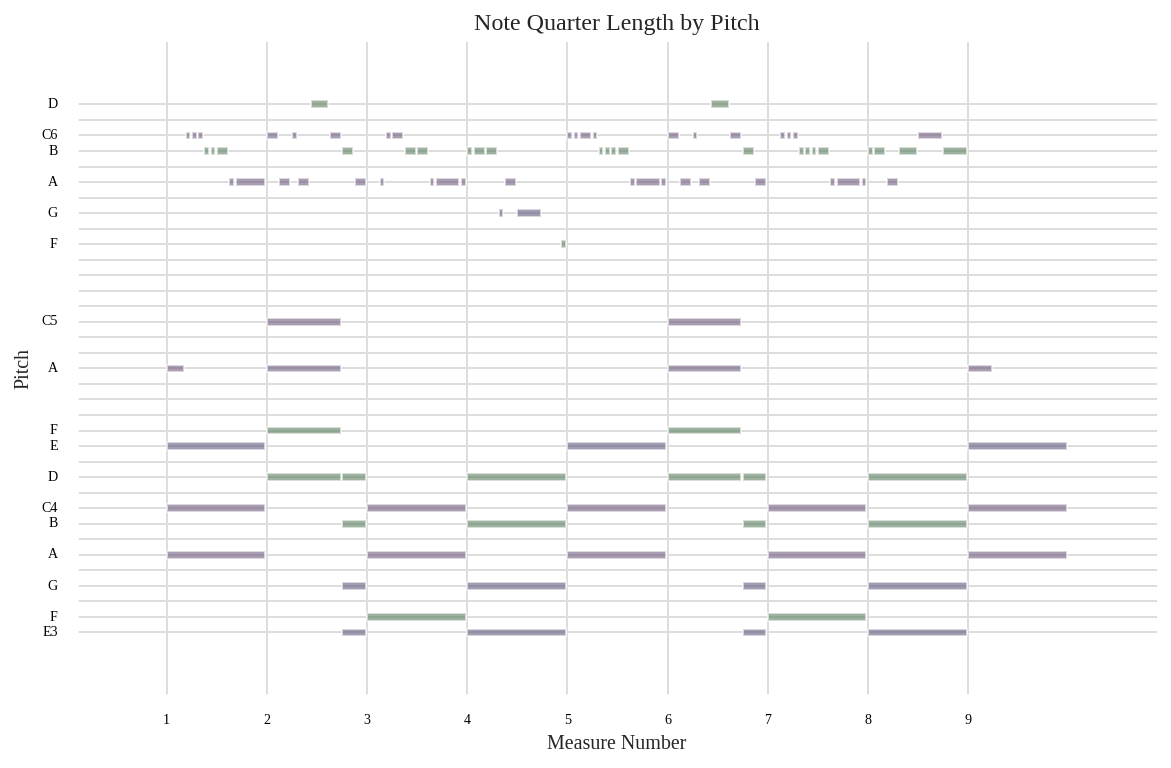

In [ ]:
sample.measures(0, 10).plot()

In [ ]:
path = midi_paths[10]
print(path)

sample = read_midi_from_archive(archive, path)
sample = translate_to_c(sample, read_mode(archive, path))
music = extract_music(sample, chords_octave_invariant=True)

def transform_notes_to_tokens(music):
  return list(map(lambda x : f"{x[0]}_{str(x[1])}", zip(music["notes"]["names"], music["notes"]["durations"])))

def transform_chords_to_tokens(music):
  return list(map(lambda x : f"{'.'.join(x[0])}_{str(x[1])}", zip(music["chords"]["names"], music["chords"]["durations"])))

transform_notes_to_tokens(music)[:10], transform_chords_to_tokens(music)[:5]

datasets/pianoroll/a/a-ha/take-on-me/intro_nokey.mid


(['REST_8.0',
  'E5_1.5',
  'C5_6.5',
  'REST_10.0',
  'E5_1.5',
  'C5_4.5',
  'A4_0.5',
  'A4_0.5',
  'F4_0.5',
  'D4_1.0'],
 ['D.F.A.E_8.0', 'REST_8.0', 'D.F.A_8.0', 'D.F.A.E_8.0', 'D.F.A_4.0'])

In [ ]:
# import music21 as mc

# with open(os.path.join(PATH, "some_parse_failures.json"), "r") as handle:
#   parse_failures = json.load(handle)

# print(len(parse_failures))
# note_only_voices = []
# chords_only = []

# for idx, path in enumerate(parse_failures):
#   sample = read_midi_from_archive(archive, path)
#   sample = translate_to_c(sample, read_mode(archive, path))

#   for x, part in enumerate(sample.parts.stream()):
#     if len(part.voices) > 0:
#       for xx, v in enumerate(part.voices):
#         most_common = _get_most_common(v)
#         if mc.chord.Chord not in map(lambda x : x[0], most_common):
#           note_only_voices.append(path)
#     else:
#       most_common = _get_most_common(part)
#       if mc.note.Note not in map(lambda x : x[0], most_common):
#           chords_only.append(path)

# mix = [p for p in note_only_voices if p in chords_only]
# print(len(mix))

"""
HOW TO PARSE files from 'parse_failures':
Some parts have VOICES.
If a voice has no CHORDS, then process it as usual.
If it has chords, then leave it for further investigation. :)

Maybe we can keep some chords in the melody too.

"""

"\nHOW TO PARSE files from 'parse_failures':\nSome parts have VOICES.\nIf a voice has no CHORDS, then process it as usual.\nIf it has chords, then leave it for further investigation. :)\n\nMaybe we can keep some chords in the melody too.\n\n"

In [ ]:
notes = []
chords = []
parse_success = []
parse_failures = []

modes = []

for idx, path in enumerate(midi_paths):

# try:
  sample = read_midi_from_archive(archive, path)
  mode = read_mode(archive, path)
  modes.append(mode)
  sample = translate_to_c(sample, mode)
  try:
    music = extract_music(sample, chords_octave_invariant=True)
  except Exception as e:
    parse_failures.append(path)
    print(path, e)
    continue

  if "notes" not in music or "chords" not in music:
    parse_failures.append(path)
    print("FAIL:", path)
    continue

  notes.append(transform_notes_to_tokens(music))
  chords.append(transform_chords_to_tokens(music))
  parse_success.append(path)

# except Exception as e:
  # print(f"Failed to read {path}\n\t{type(e)}: {str(e)}")
  # parse_failures.append(path)
  # continue  

  if idx % 100 == 0:
    print(idx)

0
100
200
300
400
500
600
700
FAIL: datasets/pianoroll/a/animusic/heavy-light/chorus-lead-out_nokey.mid
datasets/pianoroll/a/animusic/heavy-light/intro-and-verse_nokey.mid NO WAY I CAN'T IDENTIFY THOSE PARTS
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
FAIL: datasets/pianoroll/j/jean-sibelius/finlandia/intro-and-verse_nokey.mid
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
datasets/pianoroll/p/porter-robinson/fresh-static-snow/verse_nokey.mid NO WAY I CAN'T IDENTIFY THOSE PARTS
12000
12100
12200
12300
12400


In [ ]:
parsed_dict = {
    "notes": notes,
    "chords": chords,
    "parse_success": parse_success,
    "parse_failures": parse_failures
}
parsed_dict["info"] = "New parsed data. Chords are OCTAVE-INVARIANT. This means chord such as C3 E3 G3 turns into C E G"

import json

with open("parse_2.json", "w") as handle:
  json.dump(parsed_dict, handle)

In [ ]:
# OOPS! 
"""
Podstawowe przyblizenie - tam gdzie jest wiecej akordow.
Jesli to prowadzi do niejasnosci, musimy porownac czesci miedzy soba i zobaczyc gdie jest wiecej akodrow, a gdzie wiecej nut.
Oraz ktory ogolnie jest dluzszy/krotszy.

Moze jakis threshold?
Ten przypadek ponizej, wydaje sie ze nie ma tutaj melodii, sa tylko akordy i rytm gra jakas istotna role.

W niektorych nie bedzie w ogole nut. To na BANK nie nuty!
Tak samo jesli nut mniej niz chords.

PLZ INVESTIGATE THIS SZYT
"""

In [ ]:









# ________________________________________________









